# Chapter 4 : Neural Network Learning

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 손실 함수 loss function

## 오차 제곱합

$ {1 \over 2}  \displaystyle\sum_{y=y0}^{yn}{(y - t) ^ 2}$

In [2]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [3]:
import numpy as np
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [4]:
sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [7]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t))

0.5975

## 교차 엔트로피 오차

$ E = - \displaystyle\sum_{y=y0}^{yn}{tlogy}$

In [10]:
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

# delta를 더하는 이유? -> y = 0 일 경우엔 log에 들어가면 에러가 난다. 이를 방지하기 위해 매우 작은 수를 더함

In [12]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [13]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.0, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.6]
cross_entropy_error(np.array(y), np.array(t))

16.11809565095832

## mini-batch learning

mini batch는 왜 사용할까?

-> 훈련 데이터가 많으면 많을 수록 iteration의 시간이 오래 걸림, loss function의 계산에도 부하가 옴

-> 데이터의 일부를 추려 근사치로 이용하도록 함

장점

빠른 시간 내에 적당히 정확한 경로를 찾아낼 수 있음

단점

데이터 전체의 경향을 파악하지 않아 정확하지 않음

**적당히 빠른 길을 찾기 위해 사용됨**

In [3]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x_train.shape
t_train.shape


(60000, 10)

In [4]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


print(x_batch.shape[0])
print(x_batch)

10
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size) # flatten answer 
        y = y.reshape(1, y.size) # flatten output 

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y+1e-7)) / batch_size # entropy 

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size) # flatten answer 
        y = y.reshape(1, y.size) # flatten output

    batch_size = y.shape[0] 
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
'''
t -> 정답이고 batch_size -> y 갯수로 설정함
np.arange(batch_size)로 0~9 까지 생성시킴
t -> 정답 index 결국 y[0~9 , 정답 num]의 값을 가져와서 log 하는거랑 같음
'''

'\nt -> 정답이고 batch_size -> y 갯수로 설정함\nnp.arange(batch_size)로 0~9 까지 생성시킴\nt -> 정답 index 결국 y[0~9 , 정답 num]의 값을 가져와서 log 하는거랑 같음\n'

loss function을 propagation의 지표로 사용하는 이유

정확도를 기준으로 학습시키면 좋을 것 같지만, 정확도로 학습시키면 시킬수록 미분값이 0이 됨.

즉 학습이 이루어지지 않음

그렇기 때문에 손실함수를 사용함

ex) chapter3 에서의 계단함수와 시그모이드 함수 비교
    계단함수는 대부분의 구간에서 미분값이 0, 시그모이드 함수는 미분값이 거의 항상 변함

In [4]:
def numerical_diff_badcase(f, x):
    h = 1e-50
    return (f(x+h) - f(x)) / h

np.float32(1e-50)

0.0

위 미분 식이 Bad case인 이유

1. np.float32(h)를 했을 때 0이 나옴. 즉, 너무 작은 값을 사용하려하다 보니

    오히려 0으로 취급되어서 오류를 발생시킬 수 도 있음 (반올림 오차 rounding error)

2. 미분은 x위치의 함수의 기울기에 해당함. 
   
   위 함수의 구현은 (x+h)와 x사이의 기울기에 해당하기 때문에 진정한 미분과는 거리가 있음.
   
   즉, h를 0으로 무한하게 좁히는것이 불가능하기 때문에 생기는 한계이다.

In [5]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

위 중간차분법이 좋은 이유는 증명이 길기 때문에 아래 작성한 벨로그를 참고

https://velog.io/@hyunwoo02031/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5-%EC%88%98%EC%B9%98%EB%AF%B8%EB%B6%84-%EC%B0%A8%EB%B6%84%EB%B2%95%EC%97%90-%EB%94%B0%EB%A5%B8-%EC%98%A4%EC%B0%A8

h = 1e-4 로 둔 이유는 casting 시 0.0이 되지 않으면서 가장 적은 오차를 내는 h가 1e-4로 알려져 있음

In [6]:
def function_1(x):
    return 0.01 * x ** 2 + 0.1 * x

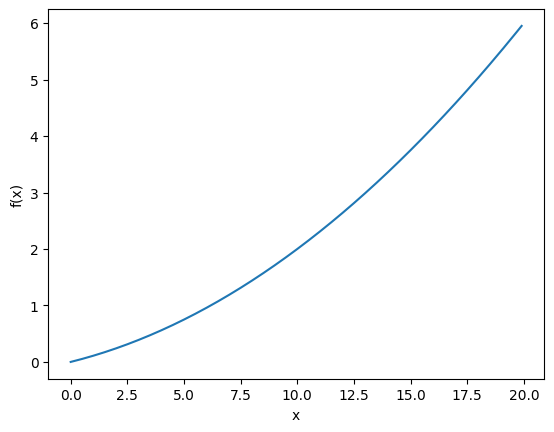

In [7]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x,y)
plt.show()

In [11]:
print(numerical_diff_badcase(function_1, 5))
print(numerical_diff(function_1, 5))

0.0
0.1999999999990898


## 편미분

$f(x0, x1) = (x0)^2 + (x1)^2$

x0 = 3, x1 = 4 일 때 x0 편미분, x1 편미분을 구현한다.

In [29]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [30]:
def function_tmp1(x0):
    return x0 * x0 + 4 ** 2

In [31]:
def function_tmp2(x1):
    return 3 ** 2 + x1 * x1

In [32]:
print(numerical_diff(function_tmp1, 3))
print(numerical_diff(function_tmp2, 4))

6.00000000000378
7.999999999999119


In [34]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
    
    return grad

In [39]:
numerical_gradient(function_2, np.array([3.0, 4.0]))
numerical_gradient(function_2, np.array([0.0, 2.0]))
numerical_gradient(function_2, np.array([3.0, 0.0]))


array([6., 0.])

# 경사법
 : 기계학습을 최적화하기 위해 사용함.
 
   현위치에서 기울어진 방향으로 조금씩 이동시키며 기울기를 측정하여 손실함수의 값을 줄어들게 만듦

In [43]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x

In [45]:
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=10))

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=0.00000001))


[-2.58983747e+13 -1.29524862e+12]
[-2.999994  3.999992]


In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [7]:
net = simpleNet()
print(net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
np.argmax(p)

t = np.array([0, 0, 1])
net.loss(x, t)

[[-0.68603858 -0.74684455  0.04812626]
 [ 1.92528321  0.39255156 -0.59877181]]
[ 1.32113173 -0.09481033 -0.51001887]


2.1697097660743663

In [8]:
def f(W):
    return net.loss(x, t)

In [9]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.42767722  0.10379592 -0.53147314]
 [ 0.64151583  0.15569388 -0.79720971]]


# 학습 알고리즘 구현하기

1 단계 : 미니배치
2 단계 : 기울기 산출
3 단계 : 매개변수 갱신
4 단계 : 반복

In [2]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(a1, W2) + b2
        y = softmax(a2)

        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
     

In [ ]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
x = np.random.rand(100, 784)
y = net.predict(x)
print(y)

t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)
print(grads)

In [7]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 2
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)

    for key in ['W1', 'b1', 'W2', 'b2']:
        network.params[key] -= learning_rate * grad[key]

    print(network.params['W1'])
    print(network.params['W2'])

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

[[ 0.00192726 -0.00995248 -0.00508157 ...  0.01084112 -0.00998404
  -0.00979663]
 [-0.01216128 -0.0088589  -0.00143952 ... -0.00804641 -0.0062289
  -0.0024923 ]
 [-0.00793773 -0.00038934 -0.01037823 ...  0.02831015  0.00933142
   0.00039595]
 ...
 [ 0.00526808 -0.01018715  0.00260303 ... -0.00161004  0.00835458
  -0.00583796]
 [-0.00677236 -0.00194073 -0.01190517 ...  0.02447219 -0.00982875
  -0.00878216]
 [ 0.00584366  0.02161194  0.00557591 ...  0.00990685 -0.0206291
   0.00148726]]
[[ 5.04625138e-03  8.30683684e-03 -1.30808552e-03 -5.49545333e-03
  -1.68798661e-02 -8.69188988e-03 -3.97108489e-03  3.75111078e-03
   3.03515104e-02  2.66555242e-03]
 [-2.87752875e-03  3.92746834e-03  3.77065994e-03  4.78376343e-03
  -1.50720754e-04 -3.07417599e-03  4.02560475e-03 -1.31135199e-02
  -6.53517231e-03  1.79801859e-03]
 [-5.37587992e-03 -4.60423666e-03  1.64842888e-03  9.62500876e-03
   1.41168350e-02  1.09178215e-02  4.25276315e-03 -1.43169089e-03
   7.52764506e-03  1.79422400e-02]
 [ 9.3009

In [ ]:
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet
import matplotlib.pylab as plt
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
iters_num = 10
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)

    for key in ['W1', 'b1', 'W2', 'b2']:
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

plt.plot(np.arange(1, len(train_acc_list)+1), train_acc_list)
plt.title("train accuracy")
plt.show()

plt.plot(np.arange(1, len(test_acc_list)+1), test_acc_list)
plt.title("test accuracy")
plt.show()